In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from numpy.linalg import norm
import pickle
from pathlib import Path 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import itertools
from collections import defaultdict
import h5py

# Data preprocessing

Import of data.

In [2]:
metadata = pd.read_csv('raw_data/articles_metadata.csv')
clicks_files_path = Path('raw_data/clicks')

Concatenation of all clicks files.

In [3]:
clicks = pd.DataFrame()

for file in clicks_files_path.glob('*.csv'):
    table_file = pd.read_csv(file)
    clicks = pd.concat([clicks, table_file], ignore_index=True)

In [4]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2


In [5]:
# Check if I have 384 hours of information.
(clicks['session_start'].max() - clicks['session_start'].min()) / 3600000

384.98777777777775

In [6]:
# Convert to datetime.
clicks['session_start'] = pd.to_datetime(clicks['session_start'], unit='ms')
clicks['click_timestamp'] = pd.to_datetime(clicks['click_timestamp'], unit='ms')
metadata['created_at_ts'] = pd.to_datetime(metadata['created_at_ts'], unit='ms')

In [7]:
# First, check if I have metadata for all article_id in clicks.
pd.merge(left=clicks, right=metadata, left_on='click_article_id', right_on='article_id', how='left', indicator=True)['_merge'].value_counts() 

_merge
both          2988181
left_only           0
right_only          0
Name: count, dtype: int64

Join clicks and metadata of articles.

In [8]:
data = pd.merge(left=clicks, right=metadata, left_on='click_article_id', right_on='article_id', how='left') 

In [9]:
data.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
0,93863,1507865792177843,2017-10-13 03:36:32,2,96210,2017-10-13 03:37:12.925,4,3,2,1,21,2,96210,209,2017-10-12 08:59:51,0,274
1,93863,1507865792177843,2017-10-13 03:36:32,2,158094,2017-10-13 03:37:42.925,4,3,2,1,21,2,158094,281,2017-10-12 10:22:31,0,223
2,294036,1507865795185844,2017-10-13 03:36:35,2,20691,2017-10-13 03:36:59.095,4,3,20,1,9,2,20691,9,2017-10-12 16:37:16,0,226
3,294036,1507865795185844,2017-10-13 03:36:35,2,96210,2017-10-13 03:37:29.095,4,3,20,1,9,2,96210,209,2017-10-12 08:59:51,0,274
4,77136,1507865796257845,2017-10-13 03:36:36,2,336245,2017-10-13 03:42:13.178,4,3,2,1,25,2,336245,437,2017-10-12 05:18:51,0,150


Now, I have to remove unrelevant data.

In [10]:
article_by_user = data.groupby('user_id', as_index=False).agg({'click_article_id': pd.Series.nunique})

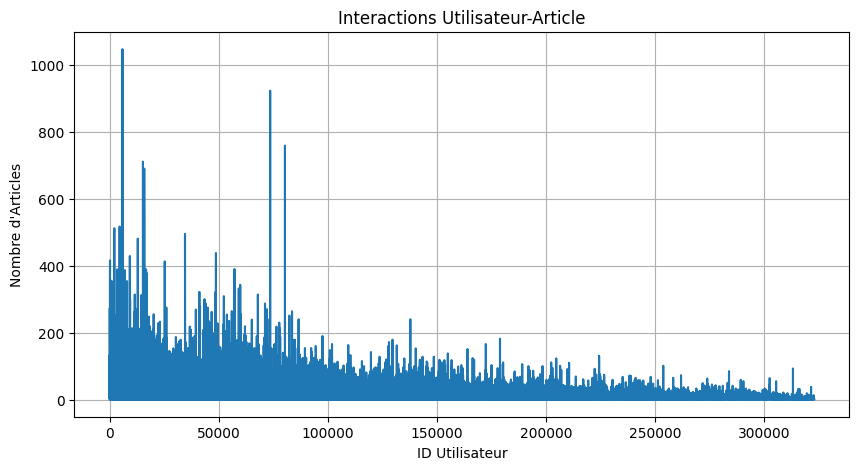

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(article_by_user['user_id'], article_by_user['click_article_id'], linestyle='-', color='#1f77b4')
plt.title('Interactions Utilisateur-Article')
plt.xlabel('ID Utilisateur')
plt.ylabel('Nombre d\'Articles')
plt.grid(True)
plt.show()

In [12]:
# Remove users who clicked on fewer than 10 articles.
users = article_by_user.loc[article_by_user['click_article_id']>10,'user_id'].to_list()

In [13]:
user_by_article = data.groupby('click_article_id', as_index=False).agg({'user_id': pd.Series.nunique})

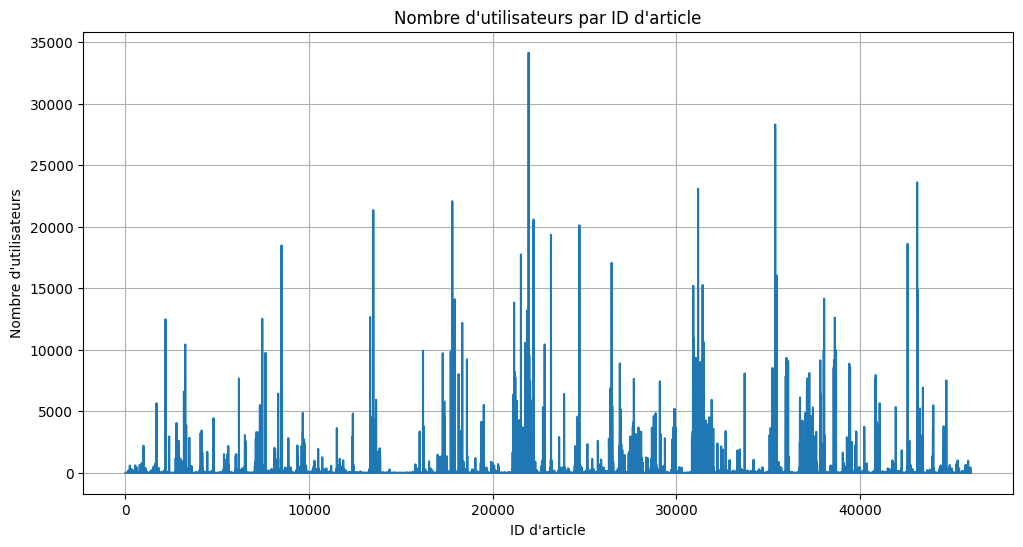

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(user_by_article['click_article_id'].index, user_by_article['user_id'], linestyle='-', color='#1f77b4')
plt.title('Nombre d\'utilisateurs par ID d\'article')
plt.xlabel('ID d\'article')
plt.ylabel('Nombre d\'utilisateurs')
plt.grid(True)
plt.show()

In [15]:
# Remove articles with fewer than 5 views.
articles = user_by_article.loc[user_by_article['user_id']>=5,'click_article_id'].to_list()

Now, keep only relevant data.

In [16]:
relevant_data = data.loc[(data['user_id'].isin(users))&(data['article_id'].isin(articles)),:]

# Train and Test sets creation

In [ ]:
#train = pd.DataFrame()
#test = pd.DataFrame()

# for user in relevant_data['user_id'].unique():
#     median_date = relevant_data.loc[relevant_data["user_id"]==user,"session_start"].median()
#     train = pd.concat([train, relevant_data.loc[(relevant_data["session_start"]<=median_date)&(relevant_data["user_id"]==user),:]])
#     test = pd.concat([test, relevant_data.loc[(relevant_data["session_start"]>median_date)&(relevant_data["user_id"]==user),:]])

In [ ]:
# Delete users in train set without futur data in test set.
#train = train.loc[train['user_id'].isin(test['user_id'].unique()),:]

# Delete users in test set without historical data in train set.
#test = test.loc[test['user_id'].isin(train['user_id'].unique()),:]

In [ ]:
#train.to_csv('prepare_data/train.csv', encoding='utf-8')
#test.to_csv('prepare_data/test.csv', encoding='utf-8')

# Baseline model

In [30]:
train = pd.read_csv('prepare_data/train.csv')
test = pd.read_csv('prepare_data/test.csv')

# Sort my data by user and temporality.
train = train.sort_values(['user_id', 'click_timestamp'], ascending=[True, True])
test = test.sort_values(['user_id', 'click_timestamp'], ascending=[True, True])

In [31]:
# Set of all unique articles and users to avoid repeated calculations
unique_articles_train = list(train['article_id'].unique())
unique_users = list(train['user_id'].unique())

In [34]:
def baseline_recommandation_model(user_id, data=train):
    most_read_articles = data[['user_id', 'click_article_id']].groupby('click_article_id').agg({'user_id': pd.Series.nunique}).sort_values('user_id', ascending=False).head()
    return list(most_read_articles.index)

def get_article_read(data:pd.DataFrame, user_id:int, user_column:str = 'user_id', article_column:str = 'article_id', number_of_article:int = 0, first:bool = True):
    if user_column not in data.columns:
        return ValueError(f"{user_column} not in dataframe provided")
    elif article_column not in data.columns:
        return ValueError(f"{article_column} not in dataframe provided")
    
    user_ids = list(data[user_column].unique())
    if user_id not in user_ids:
        return ValueError(f"{user_id} not in user in dataframe provided")
    
    if number_of_article < 0:
        return ValueError(f"{number_of_article} must be >= 0")
    
    user_article_read = list(data.loc[data['user_id'] == user_id, article_column].unique())

    if first:
        if number_of_article == 0 or number_of_article >= len(user_article_read):
            return user_article_read
        else:
            return user_article_read[:number_of_article]
    else:
        if number_of_article == 0 or number_of_article >= len(user_article_read):
            return user_article_read
        else:
            return user_article_read[-number_of_article:]

In [35]:
%%time
most_read_articles = train[['user_id', 'click_article_id']].groupby('click_article_id').agg({'user_id': pd.Series.nunique}).sort_values('user_id', ascending=False).head()
baseline_recommandation = list(most_read_articles.index)
results = list()
for user_id in unique_users:
    reality = get_article_read(data=test, user_id=user_id, number_of_article=5)
    if any(recommandation in reality for recommandation in baseline_recommandation):
        results.append(1)
    else:
        results.append(0)

CPU times: user 6min 32s, sys: 15.3 s, total: 6min 48s
Wall time: 6min 57s


In [40]:
sum(results) 

1915

# Content based model

In [41]:
with open('prepare_data/articles_embeddings.pickle', 'rb') as file:
    embedding = pickle.load(file)

train_embedding = embedding[unique_articles_train]

In [42]:
# Pre-computation before the loop
# Mapping each user to their last read article in the training dataset
similarities = cosine_similarity(train_embedding)
last_read_article_by_user = train.groupby('user_id')['article_id'].last()

Among the 364047 articles in `embedding`, `train_embedding` only keeps 11228. In order to be able to get original ID of articles, I need to map them to new ID. 

In [45]:
def similarity_score(idx1:int, idx2:int, map:list = unique_articles_train, cosinus_similarities=similarities):
    index1 = map.index(idx1)
    index2 = map.index(idx2)
    return cosinus_similarities[index1, index2]

In [43]:
def get_unread_article(user_id:int, data=train):
    read_articles = set(get_article_read(data=data, user_id=user_id))
    unread_articles = set(unique_articles_train) - read_articles
    return list(unread_articles)

In [46]:
def recommandation_based_on_n_last_read(user_id, n:int = 0):
    n_last_read_articles = get_article_read(data=train, user_id=user_id, number_of_article=n, first=False)
    unread_articles = get_unread_article(user_id)

    articles_similarities = [[unread_article] + [similarity_score(read_article, unread_article) for read_article in n_last_read_articles] for unread_article in unread_articles]
    
    articles_similarities_sum = [(article[0], sum(article[1:])) for article in articles_similarities]

    sorted_articles = sorted(articles_similarities_sum, key=lambda x: x[1], reverse=True)
    top_5_articles = sorted_articles[:5]

    return [article[0] for article in top_5_articles]

In [47]:
def evaluation_metric_n_first_article(user_id, n:int = 5):
    recommandations = recommandation_based_on_n_last_read(user_id, n=5)
    reality = get_article_read(data=test, user_id=user_id, number_of_article=n)
    if any(recommandation in reality for recommandation in recommandations):
        return 1
    else:
        return 0

In [13]:
import concurrent.futures
from tqdm import tqdm

def evaluate_all_users(user_ids):
    results = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(evaluation_metric_n_first_article, user_id): user_id for user_id in user_ids}

        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Evaluating users"):
            user_id = futures[future]
            try:
                results[user_id] = future.result()
            except Exception as e:
                print(f"Error processing user {user_id}: {e}")
    return results

In [14]:
#results = evaluate_all_users(unique_users)
#sum(list(results.values()))

Evaluating users: 100%|██████████| 75466/75466 [48:10:14<00:00,  2.30s/it]      


In [23]:
results = pd.read_csv('results.csv')

1472

In [193]:
results['prediction_result'].sum()

360

# Collaborative filtering Model Base

In [48]:
def mapping(data, user_column:str = 'user_id', article_column:str = 'article_id'):
    user_ids = list(data[user_column].unique())
    user_id_to_index = {user_column: idx for idx, user_column in enumerate(user_ids)}

    article_ids = list(data[article_column].unique())
    article_id_to_index = {article_column: idx for idx, article_column in enumerate(article_ids)}

    return user_id_to_index, article_id_to_index

def sparse_matrix(data, user_column:str = 'user_id', article_column:str = 'article_id'):
    user_ids = list(data[user_column].unique())
    article_ids = list(data[article_column].unique())
    matrice_base = np.ones(len(train), dtype=int)
    user_column_to_index, article_column_to_index = mapping(data=data)
    row_indices = train[user_column].map(user_column_to_index)
    col_indices = train[article_column].map(article_column_to_index)
    ratings_matrix = csr_matrix((matrice_base, (row_indices, col_indices)), shape=(len(user_ids), len(article_ids)))
    return ratings_matrix

In [49]:
with open("liste_client.pkl", "wb") as file:
    pickle.dump(list(train['user_id'].unique()), file)

In [50]:
import csv
with open("liste_clients.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerow(list(train['user_id'].unique()))

In [51]:
%%time
# Création des mappings
user_id_to_index, article_id_to_index = mapping(data=train)

CPU times: user 19.8 ms, sys: 2.08 ms, total: 21.8 ms
Wall time: 20.5 ms


In [52]:
# Construction de la matrice creuse en utilisant les mappings
ratings_matrix = sparse_matrix(data=train)

In [53]:
# Application SVD
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(ratings_matrix)

# user_features contient maintenant les représentations réduites des utilisateurs

In [54]:
h5file = h5py.File("user_features.h5", 'w')
h5file.create_dataset("user_features_100", data=user_features)
h5file.close()

In [55]:
# Calcul scores prédits pour chaque article pour chaque utilisateur
predicted_scores = np.dot(user_features, svd.components_)

# Normaliser les scores avec une fonction sigmoïde
predicted_scores = 1 / (1 + np.exp(-predicted_scores))

In [57]:
def predict_top_n_articles(data, user_id, svd, user_features, n:int = 5, article_column:str = 'article_id'):
    user_id_to_index, article_id_to_index = mapping(data=data)
    article_ids = list(data[article_column].unique())
    user_index = user_id_to_index[user_id]
    read_articles = get_article_read(data=train, user_id=user_id)

    # Convertir les IDs d'articles lus en indices
    read_article_indices = [article_id_to_index.get(article_id, None) for article_id in read_articles if article_id in article_id_to_index]
    
    # Calculer les scores pour tous les articles, en excluant ceux déjà lus
    scores = np.dot(user_features[user_index], svd.components_)
    # Normaliser les scores avec une fonction sigmoïde
    scores = 1 / (1 + np.exp(-scores))
    scores[read_article_indices] = -np.inf  # Exclusion des articles lus
    
    # Obtenir les indices des articles avec les plus hauts scores
    top_article_indices = np.argsort(scores)[-n:][::-1]
    
    # Convertir les indices en article_id
    top_articles = [article_ids[idx] for idx in top_article_indices]
    
    return top_articles

In [58]:
predict_top_n_articles(data=train, user_id=1, svd=svd, user_features=user_features)

[119592, 286321, 68866, 338351, 284410]

In [63]:
def collaborative_filtering_evaluation(user_ids):
    results = 0
    for user in user_ids:
        predictions = predict_top_n_articles(data=train, user_id=user, svd=svd, user_features=user_features)
        reality = get_article_read(data=test, user_id=user, number_of_article=5)
        if any(recommandation in reality for recommandation in predictions):
            results += 1

    return results

results = collaborative_filtering_evaluation(unique_users)

In [66]:
2369 *100 / len(users)

3.0908735077304454